In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.2
torchvision version: 0.16.2


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 12.93 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# Create Datasets and dataLoaders
from torchvision import transforms
from going_modular.going_modular import data_setup
# Image size
IMG_SIZE = 224
manual_transforms = transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                                    transforms.ToTensor()
                                                    ])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Defining batch size
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

(-0.5, 223.5, 223.5, -0.5)

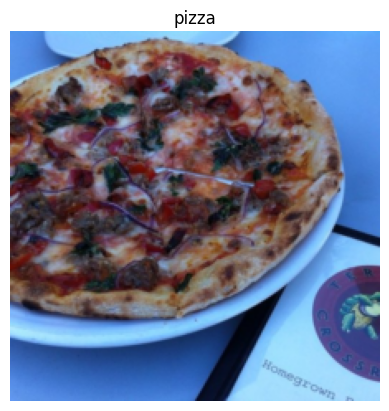

In [8]:
# Visualizing a single image
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

#view the batch shapes
import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0)) #(color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False)

# Model Architecture:
Embedding = Learnable representations, start with random numbers and improve the embedding over time
 

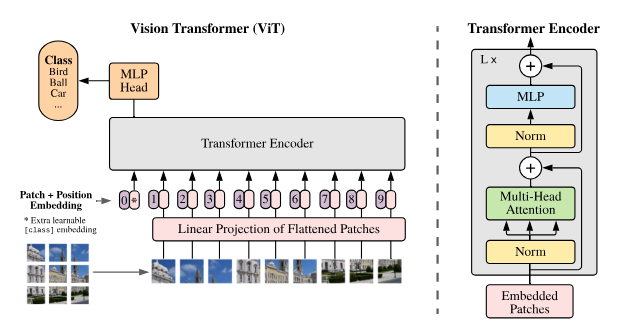

# Four equations:

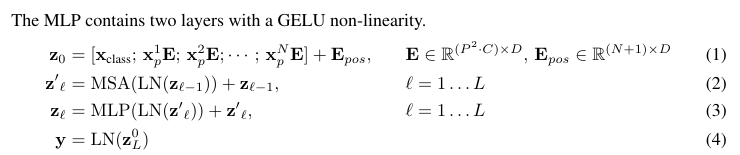


# Variants:

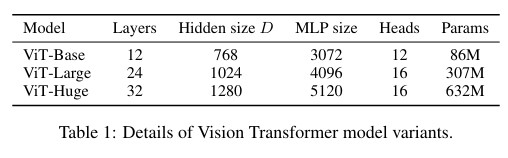

### The ViT architecture is comprised of several stages:

* Patch + Position Embedding (inputs) - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* Linear projection of flattened patches (Embedded Patches) - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.
* Norm - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm().
* Multi-Head Attention - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().
* MLP (or Multilayer perceptron) - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each (Appendex B.1).
* Transformer Encoder - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* MLP Head - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

#### Calculating patch embedding input and output shapes by hand:

We'll use a patch size ($P$) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).

According to the paper "The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings."

In [9]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width)/patch_size**2)
print(f"Number of patches (N) with image height H={height}, Width W={width} is {number_of_patches}")

Number of patches (N) with image height H=224, Width W=224 is 196


Since, 

Input: The image starts as 2D with size ${H \times W \times C}$.
Output: The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [10]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


#### Visualizing an image as patches

Number of patches per row: 14.0
 Number of patches per row: 14.0
 Number of patches per col: 14.0
 Total no. of patches: 14.0*14.0
 Patch size: 16 X 16


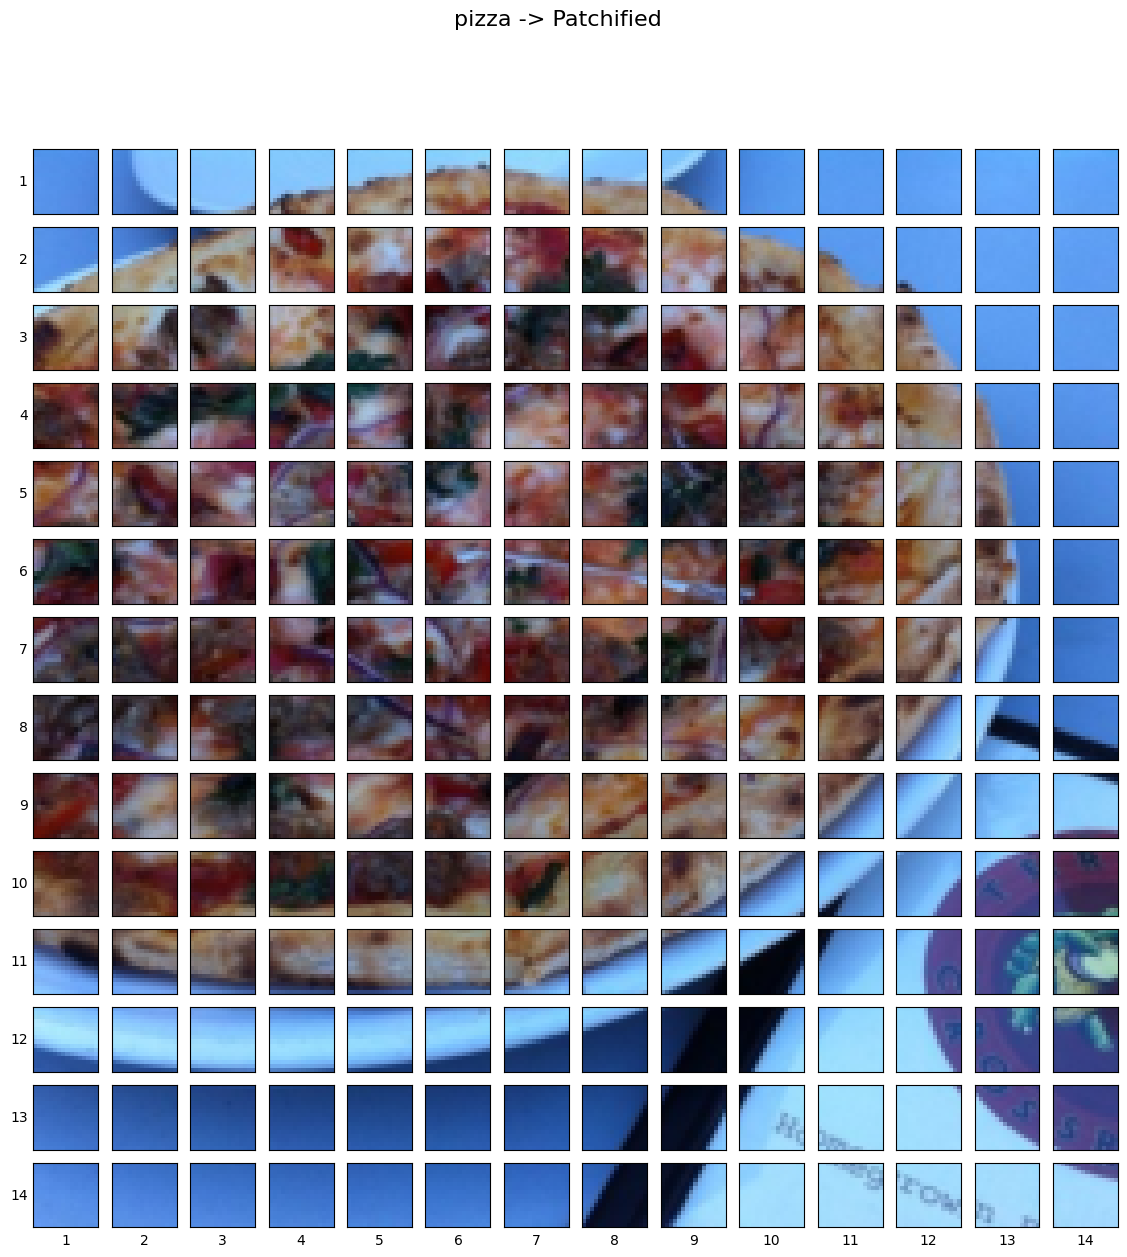

In [11]:
image_permuted = image.permute(1, 2, 0)
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size ==0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
\n Number of patches per row: {num_patches}\
\n Number of patches per col: {num_patches}\
\n Total no. of patches: {num_patches}*{num_patches}\
\n Patch size: {patch_size} X {patch_size}")

fig, axs = plt.subplots(nrows=img_size//patch_size,
                       ncols=img_size//patch_size,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)): #iterate through the height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): #iterate through the width
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                      patch_width:patch_width+patch_size,:]) # : to get all color channels
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### Creating image patches with torch.nn.Conv2d()

According to the actual ViT paper: "Hybrid Architecture. As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size $1 \times 1$, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension. The classification input embedding and position embeddings are added as described above."

The "feature map" they're refering to are the weights/activations produced by a convolutional layer passing over a given image.
By setting the kernel_size and stride parameters of a torch.nn.Conv2d() layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.

* Input: The image starts as 2D with size ${H \times W \times C}$.
* Output: The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Or for an image size of 224 and patch size of 16:

* Input (2D image): (224, 224, 3) -> (height, width, color channels)
* Output (flattened 2D patches): (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:
* torch.nn.Conv2d() for turning our image into patches of CNN feature maps.
* torch.nn.Flatten() for flattening the spatial dimensions of the feature map.

In [12]:
from torch import nn
patch_size=16
conv2d = nn.Conv2d(in_channels=3, 
                   out_channels=768, 
                   kernel_size=patch_size, 
                   stride=patch_size,
                   padding=0)
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)
image_out_of_conv_flattened = flatten(image_out_of_conv)
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size] Also the desired Output Shape")

torch.Size([1, 768, 14, 14])
Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size] Also the desired Output Shape


In [13]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image inta a 1D sequence learnable embedding"""
    def __init__(self,
                in_channels:int=3,
                patch_size:int=16,
                embedding_dim:int=768):
        super().__init__()
        # To turn an image into patches
        self.patcher=nn.Conv2d(in_channels=in_channels,
                              out_channels=embedding_dim,
                              kernel_size=patch_size,
                              stride=patch_size,
                              padding=0)
        # Create a layer to flatten the patch feature maps into a single dimension
        self.flatten=nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        image_resol = x.shape[-1]
        assert image_resol%patch_size==0, f"Input image size must be divisble by patch size, image shape: {image_resol}, patch size: {patch_size}"
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1)

In [14]:
set_seeds()
patchify = PatchEmbedding(in_channels=3,
                         patch_size=16,
                          embedding_dim=768)
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_shape = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape:{patch_embedded_shape.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape:torch.Size([1, 196, 768])


In [15]:
random_input_image = (1, 3, 224, 224)
summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### Creating the class token and positional embeddings and prepending/appending it to equation 1

According to the paper: "Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches, whose state at the output of the Transformer encoder serves as the image representation"

To do so, we can get the batch size and embedding dimension shape and then create a torch.ones() tensor in the shape [batch_size, 1, embedding_dimension].
And we'll make the tensor learnable by passing it to nn.Parameter() with requires_grad=True

In [16]:
# batch_size = patch_embedded_image.shape[0]
# embedding_dimension = patch_embedded_image.shape[2]

# class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension, required_grad=True))
# print(class_token[:,:,:10])

To summarize the entire equation one can be created as:

* Setting the patch size (we'll use 16 as it's widely used throughout the paper and for ViT-Base).
* Getting a single image, printing its shape and storing its height and width.
* Adding a batch dimension to the single image so it's compatible with our PatchEmbedding layer.
* Creating a PatchEmbedding layer (the one we made in section 4.5) with a patch_size=16 and embedding_dim=768 (from Table 1 for ViT-Base).
* Passing the single image through the PatchEmbedding layer in 4 to create a sequence of patch embeddings.
* Creating a class token embedding like in section 4.6.
* Prepending the class token embedding to the patch embeddings
* Creating a position embedding like in section 4.7.
* Adding the position embedding to the class token and patch embeddings

In [17]:
set_seeds()
patch_size = 16
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]
x=image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")
patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)
patch_embedding=patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]

#Creating class token
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dim), requires_grad=True)
print(f"Class token shape: {class_token.shape}")

#Creating positional embedding token
number_of_patches = int((height*width)/patch_size**2)
positional_token = nn.Parameter(torch.ones(batch_size,number_of_patches+1,embedding_dim), requires_grad=True)
print(f"Positional token shape: {positional_token.shape}")
patch_and_position_embedding = torch.cat((class_token, patch_embedding), dim=1) + positional_token
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Positional token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### Creating Multi-Head Attention (MSA)

If we look at the 3 equations mentioned in the paper, the 2nd equation is about multihead self attention and the equation istelf can be reffered as MSA Block
To replicate these layers and residual connection with PyTorch code we can use:

* Multi-Head Self Attention (MSA) - torch.nn.MultiheadAttention().
* Norm (LN or LayerNorm) - torch.nn.LayerNorm().
* Residual connection - add the input to output


The LayerNorm (LN) layer:
Layer Normalization (torch.nn.LayerNorm() or Norm or LayerNorm or LN) normalizes an input over the last dimension. Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data). I like to think of any kind of normalization as "getting the data into a similar format" or "getting data samples into a similar distribution". Imagine trying to walk up (or down) a set of stairs all with differing heights and lengths. It'd take some adjustment on each step right? And what you learn for each step wouldn't necessary help with the next one since they all differ, increasing the time it takes you to navigate the stairs.Normalization (including Layer Normalization) is the equivalent of making all the stairs the same height and length except the stairs are your data samples.

Originally designed for text inputs, the original self-attention mechanism takes a sequence of words and then calculates which word should pay more "attention" to another word. In other words, in the sentence "the dog jumped over the fence", perhaps the word "dog" relates strongly to "jumped" and "fence". This is simplified but the premise remains for images. Since our input is a sequence of image patches rather than words, self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.

##### Implementation details:
Query, key, value input or qkv for short which is fundamental to the self-attention mechanism. 
**In our case, the triple embedding input will be three versions of the output of the Norm layer, one for query, key and value.**

We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention() with the parameters:
* embed_dim - the embedding dimension from Table 1 (Hidden size D).
* num_heads - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 of the research paper(Heads).
* dropout - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).
* batch_first - does our batch dimension come first? (yes it does)

**Steps involved in creating this part of the network includes:**
Create a class called MultiheadSelfAttentionBlock that inherits from torch.nn.Module.
Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
* Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension (D).
* Create a multi-head attention (MSA) layer with the appropriate embed_dim, num_heads, dropout and batch_first parameters.
* Create a forward() method for our class passing the in the inputs through the LN layer and MSA layer.

In [18]:
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Creates a multi=head self-attention block ("MSA block" for short )
    """
    def __init__(self,
                embedding_dim: int=768,
                num_heads:int=12,
                attn_dropout:float=0):
        super().__init__()
        # Create the layer norm
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create the multi-head self attention MSA layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads = num_heads,
            dropout = attn_dropout,
            batch_first=True
        )
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x,
                                            key=x,
                                            value=x,
                                            need_weights=False)
        return attn_output

Note that the shape of the input which goes into the MultiheadSelfAttentionBlock is same as the output which comes out from it

In [19]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


### Creating Multilayer Perceptron (MLP)

MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above).
The term MLP is quite broad as it can refer to almost any combination of multiple layers (hence the "multi" in multilayer perceptron).
But it generally follows the pattern of:
**linear layer -> non-linear layer -> linear layer -> non-linear layer**


According to the paper: "The MLP contains two layers with a GELU non-linearity. Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings."

This means that every linear layer (or dense layer) in the MLP block has a dropout layer (torch.nn.Dropout() in PyTorch).

Where the layers refers to the linear layers (torch.nn.Linear() in PyTorch) and "GELU non-linearity is the GELU (Gaussian Error Linear Units) non-linear activation function (torch.nn.GELU() in PyTorch)"

Our MLP block will look like the following:
**layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout**

**For reference here is the table 3 mentioned in the research paper:**

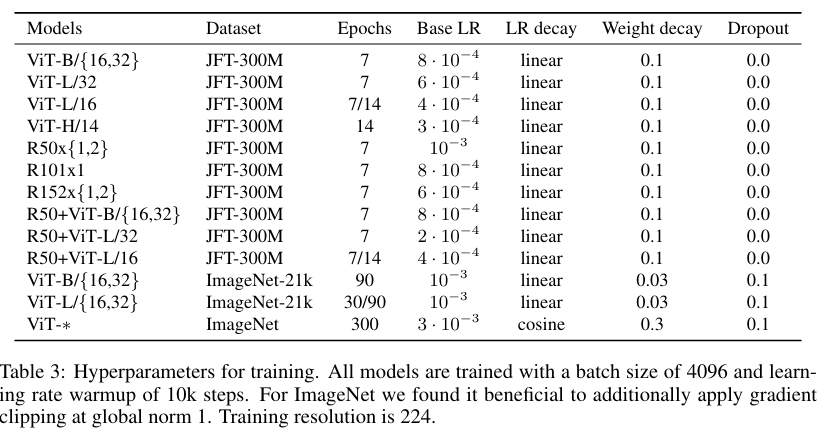

In summary the following steps need to be done to create a MLP block:
* Create a class called MLPBlock that inherits from torch.nn.Module.
* Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model. 
* Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension (Dfrom Table 1).
* Create a sequential series of MLP layers(s) using torch.nn.Linear(), torch.nn.Dropout() and torch.nn.GELU() with appropriate hyperparameter values from Table 1 and Table 3.
* Create a forward() method for our class passing the in the inputs through the LN layer and MLP layer(s).

In [20]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block") for short"""
    def __init__(self,
                embedding_dim: int=768, #Hidden size D mentioned in the table 1 for ViT-Base
                mlp_size: int=3072, # MLP size from Table 1 for ViT-Base
                dropout:float=0.1): # Dropout from table 3 for ViT-Base
        super().__init__()
        # Creating layer Normalization
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        # Creating the Multilayer Perceptron (MLP) Layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, 
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, 
                      out_features=embedding_dim),
            nn.Dropout(p=dropout),
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

Unlike the architecture, the MLPBlock() currently doesn't include a skip or residual connection, we'll include this when we create the entire Transformer encoder later on.

In [21]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


### Creating a Transformer Encoder by combining our custom made layers
Time to stack together our MultiheadSelfAttentionBlock (equation 2) and MLPBlock (equation 3) and create the Transformer Encoder of the ViT architecture.
In our case, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks, as per section 3.1 of the ViT Paper: The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

Where the subsequence output might be one or more layers later.
**In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block. And the same thing happens with the MLP block before it goes onto the next Transformer Encoder block.**

Or in pseudocode:
**x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...**

To do so, we'll:

* Create a class called TransformerEncoderBlock that inherits from torch.nn.Module.
* Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
* Instantiate a MSA block for equation 2 using our MultiheadSelfAttentionBlock from section 5.2 with the appropriate parameters.
* Instantiate a MLP block for equation 3 using our MLPBlock from section 6.2 with the appropriate parameters.
* Create a forward() method for our TransformerEncoderBlock class.
* Create a residual connection for the MSA block (for equation 2).
* Create a residual connection for the MLP block (for equation 3).

In [22]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder Block"""
    def __init__(self,
                embedding_dim: int=768, # Hidden size D from table 1 for ViT-Base 
                num_heads:int=12, # Heads from Table 1 for ViT-base
                mlp_size: int=3072, # From table 1
                mlp_dropout:float=0.1, # From table 3
                attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim = embedding_dim,
            num_heads = num_heads,
            attn_dropout = attn_dropout
        )
        self.mlp_block = MLPBlock(
            embedding_dim = embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout
        )
        
    def forward(self, x):
        # 6. Create residual connection for MSA block (add the input to the output)
        x = self.msa_block(x) + x
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x
        return x

In [23]:
transformer_encoder_block = TransformerEncoderBlock()
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

We can see our input changing shape as it moves through all of the various layers in the MSA block and MLP block of the Transformer Encoder block before finally returning to its original shape at the very end

### Creating a Transformer Encoder with PyTorch's Transformer layers
PyTorch has it's own library to implement the transformers layer. We can create the msa_block and mlp_blocks ourselves too but there is already a built in functionality available with pytorch.

For example, we can recreate the TransformerEncoderBlock we just created using torch.nn.TransformerEncoderLayer() and setting the same hyperparameters as above.

In [24]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model = 768, # The number of expected features in the input (required). (Hidden size D from Table 1 for ViT-Base)
    nhead = 12, # The number of heads in the multiheadattention models (required). (Heads from Table 1 for ViT-Base)
    dim_feedforward = 3072, # The dimension of the feedforward network model (default=2048). (MLP size from Table 1 for ViT-Base)
    dropout = 0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
    activation = "gelu", # GELU non-linear activation
    batch_first = True, # Do our batches come first?
    norm_first = True # Normalize first or after MSA/MLP layers
    )

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [25]:
summary(
        model = torch_transformer_encoder_layer,
        input_size = (1,197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

The output of the summary is slightly different to ours due to how torch.nn.TransformerEncoderLayer() constructs its layer.

But the layers it uses, number of parameters and input and output shapes are the same.

### Putting everything together: using the transformer encoder library in pytorch to create a ViT model:

The steps in volved in the process are:
* Create a class called ViT that inherits from torch.nn.Module.
* Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
* Make sure the image size is divisible by the patch size (the image should be split into even patches).
* Calculate the number of patches using the formula $N=HW/P^2$, where His the image height, W is the image width and P is the patch size.
* Create a learnable class embedding token (equation 1) as done above in section 4.6.
* Create a learnable position embedding vector (equation 1) as done above in section 4.7.
* Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper.
* Create the patch embedding layer using the PatchEmbedding class as above in section 4.5.
* Create a series of Transformer Encoder blocks by passing a list of TransformerEncoderBlocks created in section 7.1 to torch.nn.Sequential() (equations 2 & 3).
* Create the MLP head (also called classifier head or equation 4) by passing a torch.nn.LayerNorm() (LN) layer and a torch.nn.Linear(out_features=num_classes) layer (where num_classes is the target number of classes) linear layer to torch.nn.Sequential().
* Create a forward() method that accepts an input.
* Get the batch size of the input (the first dimension of the shape).
* Create the patching embedding using the layer created in step 8 (equation 1).
* Create the class token embedding using the layer created in step 5 and expand it across the number of batches found in step 11 using torch.Tensor.expand() (equation 1).
* Concatenate the class token embedding created in step 13 to the first dimension of the patch embedding created in step 12 using torch.cat() (equation 1).
* Add the position embedding created in step 6 to the patch and class token embedding created in step 14 (equation 1).
* Pass the patch and position embedding through the dropout layer created in step 7.
* Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers created in step 9 (equations 2 & 3).
* Pass index 0 of the output of the stack of Transformer Encoder layers from step 17 through the classifier head created in step 10 (equation 4).
* Dance and shout woohoo!!! We just built a Vision Transformer!

In [26]:
class ViT(nn.Module):
    """Creates a vision transformer architecture with ViT -Base hyperparameters"""
    # Initializing the hyper-parameters
    def __init__(self,
                img_size: int=224,
                in_channels:int=3,
                patch_size:int=16, # Patch size of ViT base
                num_transformer_layers: int=12, # Layers from table 1
                embedding_dim: int=768, # Hidden size D from table 1
                mlp_size: int=3072, # MLP size from table 1
                num_heads: int=12,
                attn_dropout: float=0,
                mlp_dropout: float=0.1,
                embedding_dropout: float=0.1,
                num_classes: int=1000
            ):
        super().__init__()
        assert img_size % patch_size == 0, f"Image size {img_size} must be divisble by the patch size {patch_size}"
        self.num_patches = (img_size * img_size)//patch_size**2
        
        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim), requires_grad=True)
        self.positional_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels = in_channels, 
                                             patch_size = patch_size,
                                             embedding_dim = embedding_dim)
        #Creating Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim = embedding_dim, 
                                                                           num_heads=num_heads, 
                                                                           mlp_size=mlp_size, 
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(in_features=embedding_dim,
                 out_features=num_classes)
        )
    
    def forward(self, x):
        # First step is to get the batch size
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

        
        #Creating patch embedding
        x = self.patch_embedding(x)
        
        x = torch.cat((class_token, x), dim=1)
        x = self.positional_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:,0])
        return x

In [27]:
set_seeds()
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

Finally, It looks like our random image tensor made it all the way through our ViT architecture and it's outputting three logit values (one for each class).

In [28]:
from torchinfo import summary
summary(model=vit,
       input_size = (32,3,224,224),
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"]
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

### Training the custom built ViT model:
To train our model we can import the train() function from going_modular.going_modular.engine
The authors set Adam's (Beta) values to 0.9 and 0.9999. These are the deafult values for the betas parameter in torch.optim.Adam(betas=(0.9, 0.999)).

They also state the use of weight decay (slowly reducing the values of the weights during optimization to prevent overfitting), we can set this with the weight_decay parameter in torch.optim.Adam(weight_decay=0.3) (according to the setting of ViT-* trained on ImageNet-1k).

We'll set the learning rate of the optimizer to 0.003 as per Table 3 (according to the setting of ViT-* trained on ImageNet-1k).

And as discussed previously, we're going to use a lower batch size than 4096 due to hardware limitations (if you have a large GPU, feel free to increase this).

Strangely, searching the ViT paper for "loss" or "loss function" or "criterion" returns no results.

However, since the target problem we're working with is multi-class classification (the same for the ViT paper), we'll use torch.nn.CrossEntropyLoss().

In [29]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.2680 | train_acc: 0.3594 | test_loss: 5.4419 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.0026 | train_acc: 0.3516 | test_loss: 2.0831 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2586 | train_acc: 0.4883 | test_loss: 1.7140 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2559 | train_acc: 0.2617 | test_loss: 1.3340 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1244 | train_acc: 0.4219 | test_loss: 1.2190 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1858 | train_acc: 0.3008 | test_loss: 1.1789 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2372 | train_acc: 0.2852 | test_loss: 1.2254 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1799 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1552 | train_acc: 0.3047 | test_loss: 1.0191 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2621 | train_acc: 0.2617 | test_loss: 1.3727 | test_acc: 0.2604


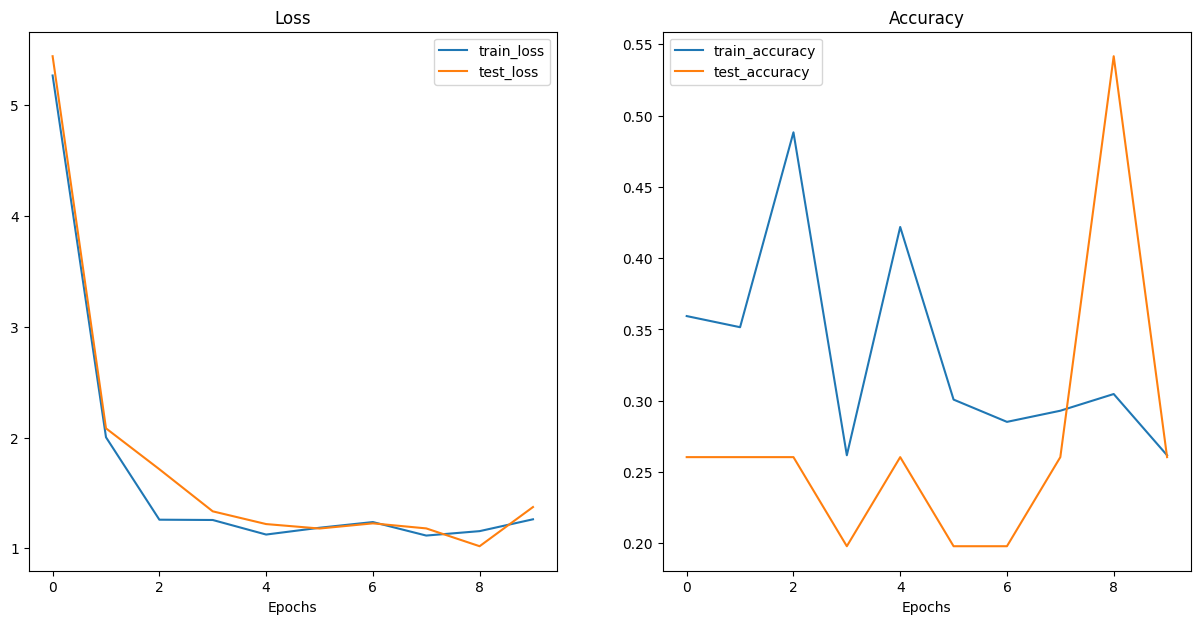

In [30]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

### Using pretrained ViT archtiture weights from torchvision

Training is computationally quite expensive and using pre-trained weights is viable option for many industrial applications

Steps involved are:
* Get the pretrained weights for ViT-Base trained on ImageNet-1k from torchvision.models.ViT_B_16_Weights.DEFAULT (DEFAULT stands for best available).
* Setup a ViT model instance via torchvision.models.vit_b_16, pass it the pretrained weights step 1 and send it to the target device.
* Freeze all of the parameters in the base ViT model created in step 2 by setting their requires_grad attribute to False.
* Update the classifier head of the ViT model created in step 2 to suit our own problem by changing the number of out_features to our number of classes (pizza, steak, sushi).

In [31]:
import torch
import torchvision 
print(torch.__version__)
print(torchvision.__version__)

2.1.2
0.16.2


In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Pretrained Vision Transformers (ViT), in industry for several reasons:

Reduced training time: Transfer learning allows models to be fine-tuned on a smaller dataset, which significantly reduces the amount of time and computational resources required for training. This is especially important for big models like ViT, which can be very resource-intensive to train from scratch.

Improved performance: By leveraging pre-trained models that have already been trained on large datasets, transfer learning can help improve the performance of models on new tasks or datasets. This is particularly beneficial for tasks where labeled data is scarce or expensive to collect.

Generalization: Pre-trained models have already learned useful features from a large amount of data, which can help improve the generalization capabilities of models on new tasks. This can lead to better performance and robustness in real-world applications.

Domain adaptation: Transfer learning allows models to adapt to new domains or tasks by fine-tuning the pre-trained model on new data. This can help improve the model's performance on specific tasks or datasets that may have different characteristics or distributions from the original training data.

In [33]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freezing the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features = len(class_names)).to(device)
# pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 180MB/s]


In [34]:
summary(model = pretrained_vit,
        input_size = (32,3,224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
    )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

And the total number of parameters, 85,800,963, is the same as our custom made ViT model above.

But the number of trainable parameters for pretrained_vit is much, much lower than our custom vit at only 2,307 compared to 85,800,963 (in our custom vit, since we're training from scratch, all parameters are trainable).

This means the pretrained model should train a lot faster, we could potentially even use a larger batch size since less parameter updates are going to be taking up memory.

In [35]:
from helper_functions import download_data
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                     destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [36]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Since we're using a pretrained model form torchvision.models we can call the transforms() method on it to get its required transforms.

**Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.**



In [37]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Since we're using a feature extractor model (less trainable parameters), we could increase the batch size to a higher value (if we set it to 1024, we'd be mimicing an improvement found in Better plain ViT baselines for ImageNet-1k, a paper which improves upon the original ViT paper and suggested extra reading). But since we only have ~200 training samples total, we'll stick with 32.

In [38]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir = train_dir,
    test_dir = test_dir,
    transform = pretrained_vit_transforms,
    batch_size = 32)

In [39]:
from going_modular.going_modular import engine
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


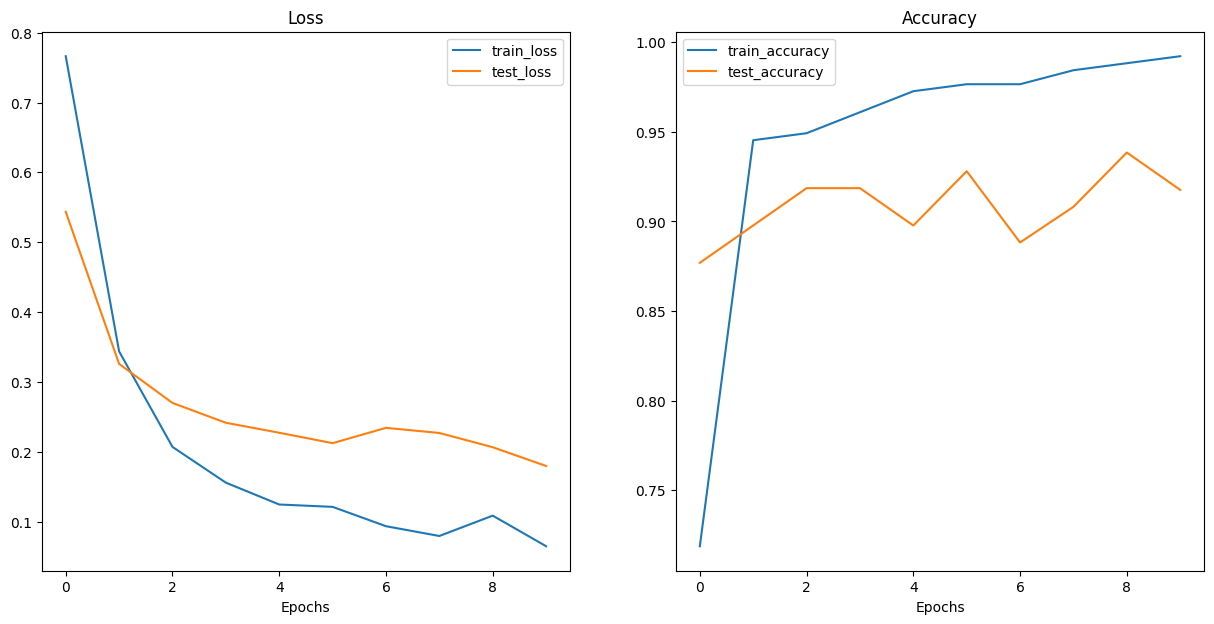

In [40]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### Save feature extractor ViT model and check file size

It looks like our ViT feature extractor model is performing quite well for our Food Vision Mini problem.

Perhaps we might want to try deploying it and see how it goes in production (in this case, deploying means putting our trained model in an application someone could use, say taking photos on their smartphone of food and seeing if our model thinks its pizza, steak or sushi).

To do so we can first save our model with the utils.save_model() function 


In [41]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


And since we're thinking about deploying this model, it'd be good to know the size of it (in megabytes or MB).

Since we want our Food Vision Mini application to run fast, generally a smaller model with good performance will be better than a larger model with great performance.

We can check the size of our model in bytes using the st_size attribute of Python's pathlib.Path().stat() method whilst passing it our model's filepath name.

In [42]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


The EffNetB2 model is ~11x smaller than the ViT model with similiar results for test loss and accuracy.

However, the ViT model's results may improve more when trained with the same data (20% pizza, steak and sushi data).

But in terms of deployment, if we were comparing these two models, something we'd need to consider is whether the extra accuracy from the ViT model is worth the ~11x increase in model size?

Perhaps such a large model would take longer to load/run and wouldn't provide as good an experience as EffNetB2 which performs similarly but at a much reduced size.

### Making a prediction on a custom image:

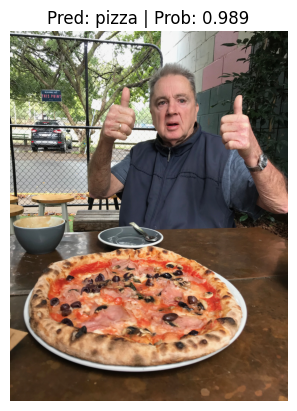

In [43]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)